# Load Data

In [2]:
pip install adversarial-robustness-toolbox

     |████████████████████████████████| 1.1 MB 7.1 MB/s 
     |████████████████████████████████| 3.3 MB 69.1 MB/s 
     |████████████████████████████████| 26.3 MB 89 kB/s 
  Attempting uninstall: llvmlite
    Found existing installation: llvmlite 0.34.0
    Uninstalling llvmlite-0.34.0:
      Successfully uninstalled llvmlite-0.34.0
  Attempting uninstall: numba
    Found existing installation: numba 0.51.2
    Uninstalling numba-0.51.2:
      Successfully uninstalled numba-0.51.2


In [3]:
from art.attacks.evasion import FastGradientMethod, BasicIterativeMethod, ProjectedGradientDescent
from art.metrics import empirical_robustness
import timeit
from art.estimators.classification import PyTorchClassifier
import numpy as np
from google.colab import drive
from torch.utils.data import DataLoader, random_split
from torch.nn.functional import nll_loss
from torchvision import transforms, datasets
import os
import torch
from PIL import Image
import matplotlib.pyplot as plt

%matplotlib inline

In [4]:
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [6]:
data_path = '/content/gdrive/My Drive/Colab Notebooks/yaledataset_recognition/yalefaces'
save_path = '/content/gdrive/My Drive/Colab Notebooks/yaledataset_recognition/preprocessing'
label_list = list()

if not os.path.isdir(save_path):
    os.mkdir(save_path)
    for file_name in os.listdir(data_path):
      if not 'gif' in file_name and not 'txt' in file_name and not 'DS_Store' in file_name:
          image = Image.open(data_path + '/' + file_name)
          subject_num = file_name.split('.')[0]
          label_list.append(subject_num)
          img_path = save_path + '/' + subject_num + '/' + file_name + '.jpg'
          
          if not os.path.isdir(save_path + '/' + subject_num):
              os.mkdir(save_path + '/' + subject_num)
          if not os.path.isfile(img_path):
              image.save(img_path)
else:
    print("Already Completed")

# len(train_img_list) # 총 data의 개수
# plt.imshow(Image.open(train_img_list[4]))
# Image.open(train_img_list[4]).size

Already Completed


In [5]:
trans = transforms.Compose([transforms.Resize((150,150)),
                            transforms.ToTensor(),
                            transforms.Grayscale(num_output_channels=1)
                            ])
dataset = datasets.ImageFolder(root = '/content/gdrive/My Drive/Colab Notebooks/yaledataset_recognition/preprocessing/', transform = trans)

train_dataset, test_dataset  = random_split(dataset, [130,34])

In [6]:
x_test_new = np.array([])
y_test_new = np.array([])

for data in test_dataset:
  # print(np.array(data[0]))
  # break
  if x_test_new.size == 0:
    x_test_new = np.array(data[0].unsqueeze(0))
  else:
    x_test_new = np.concatenate((x_test_new, np.array(data[0].unsqueeze(0))), axis=0)
  y_test_new = np.append(y_test_new, data[1])

In [88]:
x_test_new.shape

(34, 1, 150, 150)

In [7]:
import numpy as np
import torch
from torch import nn
from torch.autograd import Variable


def get_output_size(network):
    if type(network) != list:
        network = [network]
        
    output = Variable(torch.ones(1, 1, 150, 150))
    for conv in network:
        output = conv.forward(output)
    
    # return np.asscalar(np.prod(output.data.shape)), output.data.size()[2]
    return np.prod(output.data.shape)


class ConvLayer(nn.Module):
    def __init__(self, in_c, out_c, kernel_size=5, max_pool_stride=2):
        super(ConvLayer, self).__init__()
        self.conv1 = nn.Conv2d(in_c, out_c, kernel_size=kernel_size)
        self.conv2 = nn.Conv2d(out_c, out_c, kernel_size=kernel_size)
        self.max_pool2d = nn.MaxPool2d(kernel_size=2, stride=max_pool_stride)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.conv2(self.relu(self.conv1(x))))
        return self.max_pool2d(x)


class Network(nn.Module):
    def __init__(self):
        super(Network, self).__init__()
        self.convs = []
        self.convs.append(ConvLayer(1, 32, kernel_size=5))
        self.convs.append(ConvLayer(32, 64, kernel_size=5))
        conv_output_size = get_output_size(self.convs)
        self.fully_connected1 = nn.Linear(conv_output_size, 1024)
        self.fully_connected2 = nn.Linear(1024, 15)

    def forward(self, x):
        for conv in self.convs:
            x = conv(x)
        x = x.view(x.size(0), -1)
        x = nn.functional.relu(self.fully_connected1(x))
        return nn.functional.log_softmax(self.fully_connected2(x))

In [8]:
model = torch.load('/content/gdrive/My Drive/Colab Notebooks/yaledataset_recognition/'+'model.pt')

classifier = PyTorchClassifier(model=model,
                                    nb_classes=15,
                                    clip_values=(0.0, 1.0),
                                    input_shape=tuple(train_dataset[0][0].shape[1:]),
                                    loss=torch.nn.CrossEntropyLoss())

In [17]:
ORIGIN_predictions = classifier.predict(x_test_new)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


In [9]:
FGM = FastGradientMethod(classifier, norm = "inf", 
                        eps=0.1, eps_step=0.1, targeted=False,
                        num_random_init=0,
                        batch_size=16,
                        minimal=True)

start = timeit.default_timer()
FGM_test_adv = FGM.generate(x_test_new)
stop = timeit.default_timer()

print('Time: ', stop - start)

FGM_predictions = classifier.predict(FGM_test_adv)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Time:  12.206091768000022


In [10]:
BIM = BasicIterativeMethod(classifier,
                        eps=0.2, eps_step=0.1, targeted=False,
                        max_iter=50,
                        batch_size=16,
                        verbose=True
                        )

start = timeit.default_timer()
BIM_test_adv = BIM.generate(x_test_new)
stop = timeit.default_timer()

print('Time: ', stop - start)

BIM_predictions = classifier.predict(BIM_test_adv)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


PGD - Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Time:  274.67001495500006


In [11]:
PGD = ProjectedGradientDescent(classifier, norm = "inf", 
                        eps=0.2, eps_step=0.1, targeted=False,
                        random_eps=True,
                        max_iter=50,
                        num_random_init=0,
                        batch_size=16,
                        )

start = timeit.default_timer()
PGD_test_adv = PGD.generate(x_test_new)
stop = timeit.default_timer()

print('Time: ', stop - start)

PGD_predictions = classifier.predict(PGD_test_adv)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


PGD - Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Time:  274.361513253


In [240]:
import cv2

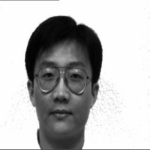

In [12]:
original_image = Image.fromarray((x_test_new[10]*255).astype(np.uint8).squeeze())
FGM_image = Image.fromarray((FGM_test_adv[10]*255).astype(np.uint8).squeeze())
BIM_image = Image.fromarray((BIM_test_adv[10]*255).astype(np.uint8).squeeze())
PGD_image = Image.fromarray((PGD_test_adv[10]*255).astype(np.uint8).squeeze())

original_image

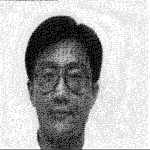

In [13]:
FGM_image

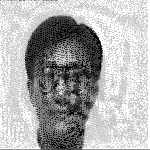

In [14]:
BIM_image

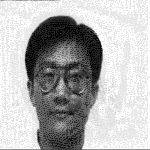

In [15]:
PGD_image

In [19]:
correct = 0
index = 0
for predict in ORIGIN_predictions:
  pred = np.argmax(predict)
  if pred == y_test_new[index]:
    correct += 1
  
  index += 1

print("ORIGINAL Accuracy : " + str(correct/len(y_test_new)))

correct = 0
index = 0
for predict in FGM_predictions:
  pred = np.argmax(predict)
  if pred == y_test_new[index]:
    correct += 1
  
  index += 1

print("FGM Accuracy : " + str(correct/len(y_test_new)))

correct = 0
index = 0
for predict in BIM_predictions:
  pred = np.argmax(predict)
  if pred == y_test_new[index]:
    correct += 1
  
  index += 1

print("BIM Accuracy : " + str(correct/len(y_test_new)))

correct = 0
index = 0
for predict in PGD_predictions:
  pred = np.argmax(predict)
  if pred == y_test_new[index]:
    correct += 1
  
  index += 1

print("PGD Accuracy : " + str(correct/len(y_test_new)))

ORIGINAL Accuracy : 0.9705882352941176
FGM Accuracy : 0.9411764705882353
BIM Accuracy : 0.029411764705882353
PGD Accuracy : 0.47058823529411764


In [320]:
empirical_robustness(classifier,
                      x=x_test_new,
                      attack_name='fgsm',
                     attack_params={'norm':np.inf}
                     )

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


0.1864181